# JAM FITTER

In [1]:
import fitpack

In [2]:
import sys,os
from fitlab.resman import RESMAN
from fitlab.mcsamp import MCSAMP
from tools.config import load_config,conf
from tools.tools import load, save,checkdir
import pylab as py
import numpy as np
import pandas as pd
import copy
def lprint(msg):
    sys.stdout.write('\r')
    sys.stdout.write('%s' %msg)
    sys.stdout.flush()
%matplotlib inline

## dy parameters

In [3]:
dy = 3
# Inputs
summary_dy = '../samples/summary_dy3.mcp'
config_dy = '../inputs/upol_hermes_alexei3.py'
# out
sid_dy = 'sidis_dy3.dat'
dat_thy_dy = 'data_and_thy_dy3.dat'
fig_seperation_dy = "separation_dy3.pdf"
fig_hermes_dy = "hermes_fit_dy3.pdf"


## setup path to store the results 

In [4]:
path2results='sidis_hermes_torino_alexei_dy'
checkdir(path2results)

## data sets 

In [5]:
conf['datasets']={}

## SIDIS FUU 

In [6]:
conf['datasets']['sidis']={}
conf['datasets']['sidis']['filters']={}
conf['datasets']['sidis']['filters'][0]={}
conf['datasets']['sidis']['filters'][0]['idx']=[1000,1001,1004,1005,1002,1003,1006,1007]
conf['datasets']['sidis']['filters'][0]['filter']="z>0.2 and z<0.6 and Q2>1.69 and (pT/z)**2<0.25*Q2 and dy>3"
#conf['datasets']['sidis']['filters'][0]['filter']="z>0.2 and z<0.6 and Q2>1."
#conf['datasets']['sidis']['filters'][0]['filter']="z>0.2 and z<0.6 and Q2>1.69 and pT>0.2 and pT<0.9"




conf['datasets']['sidis']['xlsx']={}
conf['datasets']['sidis']['xlsx'][1000]='sidis/expdata/1000.xlsx'  # |  proton   | pi+    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1001]='sidis/expdata/1001.xlsx'  # |  proton   | pi-    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1004]='sidis/expdata/1004.xlsx'  # |  deuteron | pi+    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1005]='sidis/expdata/1005.xlsx'  # |  deuteron | pi-    | M_Hermes | hermes 

conf['datasets']['sidis']['xlsx'][1002]='sidis/expdata/1002.xlsx'  # |  proton   | k+    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1003]='sidis/expdata/1003.xlsx'  # |  proton   | k-    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1006]='sidis/expdata/1006.xlsx'  # |  deuteron | k+    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1007]='sidis/expdata/1007.xlsx'  # |  deuteron | k-    | M_Hermes | hermes 

conf['datasets']['sidis']['norm']={}
for k in conf['datasets']['sidis']['xlsx']: conf['datasets']['sidis']['norm'][k]={'value':1,'fixed':True,'min':0,'max':1} 


## parameters

In [7]:
conf['params']={}
conf['basis']='default'

### PDF parameters

In [8]:
conf['params']['pdf']={}
conf['params']['pdf']['widths0 valence']  = {'value':0.52414,'fixed':False,'min':0.3,'max':0.7}
conf['params']['pdf']['widths0 sea']      = {'value':0.58465,'fixed':False,'min':0.2,'max':1.}

In [9]:
conf['params']['ff']={}
conf['params']['ff']['widths0 pi+ fav']   = {'value':0.12405,'fixed':False,'min':0.1,'max':0.2}
conf['params']['ff']['widths0 pi+ unfav'] = {'value':0.14373,'fixed':False,'min':0.1,'max':0.2}
conf['params']['ff']['widths0 k+ fav']    = {'value':0.13384,'fixed':False,'min':0.1,'max':0.2}
conf['params']['ff']['widths0 k+ unfav']  = {'value':0.20266,'fixed':False,'min':0.05,'max':0.3}

### combine multiple runs into one big run

In [10]:
runs=load(summary_dy)

In [11]:
load_config(config_dy)
conf['resman']=RESMAN(mode='solo',ip=None,nworkers=None)

loading sidis data sets 1007

### distribution of parameters

In [12]:
tab={}
tab['nll']=runs['all']['nll']
tab['weights']=runs['all']['weights']
samples=np.transpose(runs['all']['samples'])
for i in range(len(conf['parman'].order)):
   _,kind,par=conf['parman'].order[i]
   tab['%s-%s'%(kind,par)]=samples[i]
tab=pd.DataFrame(tab)

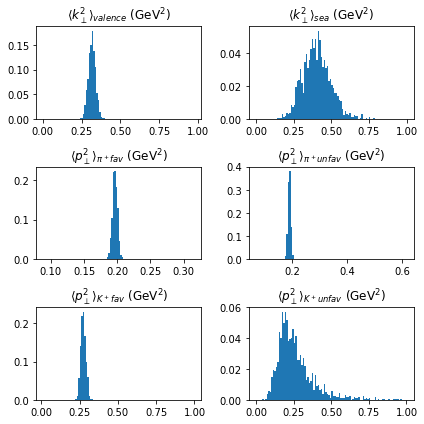

In [13]:
nrows,ncols=3,2
fig = py.figure(figsize=(ncols*3,nrows*2))


def title(par):
    if par == 'widths0 valence':
        return r"$\langle k_\perp^2 \rangle_{valence}$ (GeV$^2$)"
    if par == 'widths0 sea':
        return r"$\langle k_\perp^2 \rangle_{sea}$ (GeV$^2$)"
    if par == 'widths0 pi+ fav':
        return r"$\langle p_\perp^2 \rangle_{\pi^+ fav}$ (GeV$^2$)"
    if par == 'widths0 pi+ unfav':
        return r"$\langle p_\perp^2 \rangle_{\pi^+ unfav}$ (GeV$^2$)"
    if par == 'widths0 k+ fav':
        return r"$\langle p_\perp^2 \rangle_{K^+ fav}$ (GeV$^2$)"
    if par == 'widths0 k+ unfav':
        return r"$\langle p_\perp^2 \rangle_{K^+ unfav}$ (GeV$^2$)"



global cnt
cnt=0
def plot(tags):
   global cnt
   for i in range(len(tags)):
       cnt+=1
       if tags[i]==None: continue
       ax=py.subplot(nrows,ncols,cnt)
       kind,par=tags[i].split('-')
       if kind=='pdf':
           vmin=conf['params']['pdf'][par]['min']
           vmax=conf['params']['pdf'][par]['max']
           R=(vmin,vmax)
       elif kind=='ff':
           vmin=conf['params']['ff'][par]['min']
           vmax=conf['params']['ff'][par]['max']
           R=(vmin,vmax)
       elif kind=='sidis':
           vmin=conf['datasets']['sidis']['norm'][int(par)]['min']
           vmax=conf['datasets']['sidis']['norm'][int(par)]['max']
           R=(vmin,vmax)

       R=None
       #for k in runs:
       #    ax.hist(runs[k]['samples'].T[idx],weights=runs[k]['weights'],bins=50,normed=True,range=R)
       #ax.hist(tab[tags[i]],normed=True)
       #tabk=tab.query('nll<1300')
       ax.hist(tab[tags[i]],range=R,bins=100,weights=tab['weights'])
       #ax.set_title(par)
       ax.set_title(title(par))

       
       #print samples.T[idx]
       #print weights
       #ax.hist(samples2.T[idx],weights=weights2,bins=50,color='r',histtype='step',normed=True,range=R)
       #ax.set_title(tags[i])
       #ax.set_xlim(vmin,vmax)
   py.tight_layout()


plot(['pdf-widths0 valence','pdf-widths0 sea'])
plot(['ff-widths0 pi+ fav','ff-widths0 pi+ unfav'])
plot(['ff-widths0 k+ fav','ff-widths0 k+ unfav'])



## data vs theory

In [14]:
data={'weights':runs['all']['weights']}
cnt=0
for s in runs['all']['samples']:
    cnt+=1    
    lprint('%d/%d'%(cnt,len(runs['all']['samples'])))  
    conf['resman'].get_residuals(s);
    for k in conf['resman'].sidisres.tabs:
        if k  not in data: data[k]=[]
        thy=conf['resman'].sidisres.tabs[k]['thy']    
        norm=conf['datasets']['sidis']['norm'][k]['value']
        shift=conf['resman'].sidisres.tabs[k]['shift']        
        data[k].append(shift+thy/norm)
save(data,'%s/%s'%(path2results, sid_dy))   

5683/5683

### compute averages and collect results

In [15]:
data=load('%s/%s'%(path2results, sid_dy))   
for k in data: data[k]=np.array(data[k])
thy,dthy={},{}
for k in data:
    if k=='weights': continue
    thy[k]=np.einsum('i,ik->k',data['weights'],data[k])
    dthy[k]=np.einsum('i,ik->k',data['weights'],(data[k]-thy[k])**2)**0.5
for k in thy: 
    conf['resman'].sidisres.tabs[k]['thy']=copy.copy(thy[k])
    conf['resman'].sidisres.tabs[k]['dthy']=copy.copy(dthy[k])

In [16]:
report=conf['resman'].gen_report(verb=0,level=1)
delimiters=[]
for i in range(len(report)): 
    if 'reaction:' in report[i]: delimiters.append(i) 

data={}
nlines=len(report)
for i in range(len(delimiters)):
    ini=delimiters[i]
    if i==len(delimiters)-1: fin=len(report)
    else: fin=delimiters[i+1]
    reaction=report[ini].replace('reaction:','').strip()
    data[reaction]={'raw data':report[ini:fin]}
    
for k in data:
    print k
    block=data[k]['raw data']
    isep=[i for i in range(len(block)) if '--------' in block[i]][0]
    data[k]['summary']=[block[i] for i in range(isep)]
    data[k]['tables']=[block[i] for i in range(isep+1,len(block))]

    tabs={}
    for l in data[k]['tables']:
        info=l.split(',')
        col=[s for s in info if 'col' in s][0].split('=')[1].strip()
        if col not in tabs: tabs[col]={}
        info=[[ss.strip() for ss in s.split('=')] for s in info if 'col' not in info  if s.strip()!='']
        
        for s in info:
            if s[0] not in tabs[col]: tabs[col][s[0]]=[]
        
        for s in info:
            try:
                value=float(s[1])
            except:
                value=s[1]
            tabs[col][s[0]].append(value)        

    data[k]['tabs']=tabs
save(data,'%s/%s'%(path2results, dat_thy_dy))  

sidis


In [17]:
def summary():
    for k in data:
        print ""
        for l in data[k]['summary']: print l
summary()


reaction: sidis
    idx        tar        had        col        obs  npts       chi2      rchi2      nchi2
   1000     proton        pi+     hermes   M_Hermes    52     119.79       0.00       0.00
   1001     proton        pi-     hermes   M_Hermes    53      91.75       0.00       0.00
   1002     proton         k+     hermes   M_Hermes     9      18.51       0.00       0.00
   1003     proton         k-     hermes   M_Hermes     7       4.17       0.00       0.00
   1004   deuteron        pi+     hermes   M_Hermes    52      87.84       0.00       0.00
   1005   deuteron        pi-     hermes   M_Hermes    53      78.10       0.00       0.00
   1006   deuteron         k+     hermes   M_Hermes    10       5.82       0.00       0.00
   1007   deuteron         k-     hermes   M_Hermes    10       4.12       0.00       0.00


### distribution of parameters

In [18]:
np.amin(tab['pdf-widths0 valence'])

0.007190124313661284

0.31803775834818426 0.02345847007049021


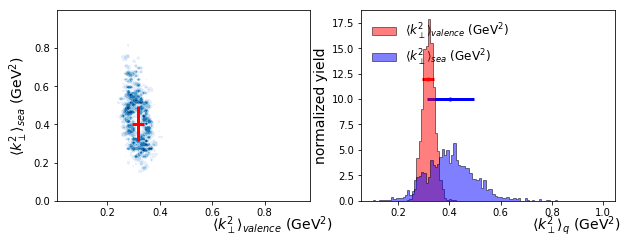

In [19]:
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.mlab import griddata


nrows,ncols=1,2
py.figure(figsize=(ncols*5,nrows*3.5))

samples2=runs['all']['samples']
weights2=runs['all']['weights']

ax=py.subplot(121)

xgrid = np.linspace(np.amin(tab['pdf-widths0 valence']), np.amax(tab['pdf-widths0 valence']), 100)
ygrid = np.linspace(np.amin(tab['pdf-widths0 sea']), np.amax(tab['pdf-widths0 sea']), 100)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(tab['pdf-widths0 valence'],tab['pdf-widths0 sea'],weights2, xgrid, ygrid,interp='linear')
zgrid/=np.amax(zgrid)
ax.contourf(xgrid, ygrid, zgrid,cmap=cm.Blues,levels=[0.15,0.3,0.45,0.6,0.75,0.9,1.05])

meanval=np.einsum('i,i',tab['pdf-widths0 valence'],weights2)
stdval=np.einsum('i,i',(tab['pdf-widths0 valence']-meanval)**2,weights2)**0.5

meansea=np.einsum('i,i',tab['pdf-widths0 sea'],weights2)
stdsea=np.einsum('i,i',(tab['pdf-widths0 sea']-meansea)**2,weights2)**0.5


ax.errorbar([meanval],[meansea],xerr=stdval,yerr=stdsea,fmt='r.',elinewidth=3,alpha=1.)
 
#ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
ax.set_xlabel(r"$\langle k_\perp^2 \rangle_{valence}$ (GeV$^2$)",size=14)
ax.xaxis.set_label_coords(0.85, -0.07)
#ax.set_xlim(0.0,0.55)
#ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
#ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.2}$','',r'$\boldsymbol{0.4}$',''])
ax.set_ylabel(r"$\langle k_\perp^2 \rangle_{sea}$ (GeV$^2$)",size=14)

##############################################
ax=py.subplot(122)

R=(0.1,1.)
bins=100

ax.hist(tab['pdf-widths0 valence'],histtype='stepfilled',range=R,weights=weights2,bins=bins,facecolor='r'\
   ,edgecolor='k'\
   ,label=r"$\langle k_\perp^2 \rangle_{valence}$ (GeV$^2$)",normed=True,alpha=0.5,zorder=10);

ax.hist(tab['pdf-widths0 sea'],histtype='stepfilled',range=R,weights=weights2,bins=bins,facecolor='b'\
   ,edgecolor='k'\
   ,label=r"$\langle k_\perp^2 \rangle_{sea}$ (GeV$^2$)",normed=True,alpha=0.5,zorder=10);


ax.errorbar([meansea],10,xerr=stdsea,yerr=0,fmt='b.',elinewidth=3,alpha=1.)

ax.errorbar([meanval],12,xerr=stdval,yerr=0,fmt='r.',elinewidth=3,alpha=1.)

meanfffav=np.einsum('i,i',tab['ff-widths0 pi+ fav'],weights2)
stdfffav=np.einsum('i,i',(tab['ff-widths0 pi+ fav']-meanfffav)**2,weights2)**0.5

meanffunfav=np.einsum('i,i',tab['ff-widths0 pi+ unfav'],weights2)
stdffunfav=np.einsum('i,i',(tab['ff-widths0 pi+ unfav']-meanffunfav)**2,weights2)**0.5

meanffkfav=np.einsum('i,i',tab['ff-widths0 k+ fav'],weights2)
stdffkfav=np.einsum('i,i',(tab['ff-widths0 k+ fav']-meanffkfav)**2,weights2)**0.5

meanffkunfav=np.einsum('i,i',tab['ff-widths0 k+ unfav'],weights2)
stdffkunfav=np.einsum('i,i',(tab['ff-widths0 k+ unfav']-meanffkunfav)**2,weights2)**0.5



descriptive_stat = [[float(meanval), stdval], [float(meansea), stdsea], [float(meanfffav),stdfffav],
                    [float(meanffunfav),stdffunfav], [float(meanffkfav),stdffkfav],
                    [float(meanffkunfav),stdffkunfav]]


print meanval, stdval

#ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
ax.set_xlabel(r"$\langle k_\perp^2 \rangle_{q}$ (GeV$^2$)",size=14)
#ax.set_xlim([0,1.5])
#ax.set_xticks([0,0.25,0.5,0.75,1,1.25])
#ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.5}$','',r'$\boldsymbol{1}$',''])
ax.xaxis.set_label_coords(0.85, -0.07)
ax.set_ylabel(r'normalized yield',size=14)
#ax.set_ylim([0,7.5])
#ax.set_yticks([0,2,4,6])
#ax.set_yticklabels([r'$\boldsymbol{0}$',r'$\boldsymbol{2}$',r'$\boldsymbol{4}$',r'$\boldsymbol{6}$'])
ax.legend(frameon=False,fontsize=12,loc=2)
#ax.text(0.87,0.87,r'$\boldsymbol{\rm (b)}$',size=20,transform=ax.transAxes,color='k',alpha=1)

#py.tight_layout()
py.savefig("%s/%s" % (path2results, fig_seperation_dy))



In [20]:
descriptive_stat

[[0.31803775834818426, 0.02345847007049021],
 [0.40410797382674846, 0.09246721823592821],
 [0.19675144955477147, 0.0039133183327877364],
 [0.1896060989406973, 0.005053559800934697],
 [0.2755202834642893, 0.016511628633215484],
 [0.26088392885200856, 0.11968176614392852]]

0.31803775834818426 0.02345847007049021


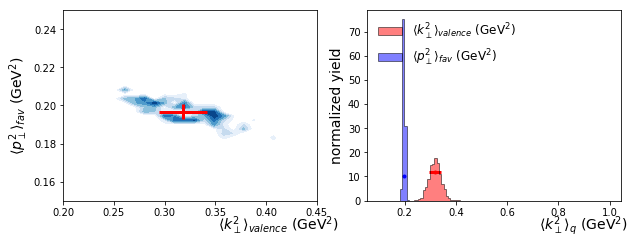

In [21]:
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.mlab import griddata


nrows,ncols=1,2
py.figure(figsize=(ncols*5,nrows*3.5))

samples2=runs['all']['samples']
weights2=runs['all']['weights']

ax=py.subplot(121)

xgrid = np.linspace(np.amin(tab['pdf-widths0 valence']), np.amax(tab['pdf-widths0 valence']), 100)
ygrid = np.linspace(np.amin(tab['ff-widths0 pi+ fav']), np.amax(tab['ff-widths0 pi+ fav']), 100)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(tab['pdf-widths0 valence'],tab['ff-widths0 pi+ fav'],weights2, xgrid, ygrid,interp='linear')
zgrid/=np.amax(zgrid)
ax.contourf(xgrid, ygrid, zgrid,cmap=cm.Blues,levels=[0.15,0.3,0.45,0.6,0.75,0.9,1.05])

meanval=np.einsum('i,i',tab['pdf-widths0 valence'],weights2)
stdval=np.einsum('i,i',(tab['pdf-widths0 valence']-meanval)**2,weights2)**0.5

meansea=np.einsum('i,i',tab['ff-widths0 pi+ fav'],weights2)
stdsea=np.einsum('i,i',(tab['ff-widths0 pi+ fav']-meansea)**2,weights2)**0.5


ax.errorbar([meanval],[meansea],xerr=stdval,yerr=stdsea,fmt='r.',elinewidth=3,alpha=1.)
 
#ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
ax.set_xlabel(r"$\langle k_\perp^2 \rangle_{valence}$ (GeV$^2$)",size=14)
ax.xaxis.set_label_coords(0.85, -0.07)
ax.set_xlim(0.2,0.45)
ax.set_ylim(0.15,0.25)
#ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
#ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.2}$','',r'$\boldsymbol{0.4}$',''])
ax.set_ylabel(r"$\langle p_\perp^2 \rangle_{fav}$ (GeV$^2$)",size=14)

##############################################
ax=py.subplot(122)

R=(0.1,1.)
bins=100

ax.hist(tab['pdf-widths0 valence'],histtype='stepfilled',range=R,weights=weights2,bins=bins,facecolor='r'\
   ,edgecolor='k'\
   ,label=r"$\langle k_\perp^2 \rangle_{valence}$ (GeV$^2$)",normed=True,alpha=0.5,zorder=10);

ax.hist(tab['ff-widths0 pi+ fav'],histtype='stepfilled',range=R,weights=weights2,bins=bins,facecolor='b'\
   ,edgecolor='k'\
   ,label=r"$\langle p_\perp^2 \rangle_{fav}$ (GeV$^2$)",normed=True,alpha=0.5,zorder=10);


ax.errorbar([meansea],10,xerr=stdsea,yerr=0,fmt='b.',elinewidth=3,alpha=1.)

ax.errorbar([meanval],12,xerr=stdval,yerr=0,fmt='r.',elinewidth=3,alpha=1.)


print meanval, stdval

#ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
ax.set_xlabel(r"$\langle k_\perp^2 \rangle_{q}$ (GeV$^2$)",size=14)
#ax.set_xlim([0,1.5])
#ax.set_xticks([0,0.25,0.5,0.75,1,1.25])
#ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.5}$','',r'$\boldsymbol{1}$',''])
ax.xaxis.set_label_coords(0.85, -0.07)
ax.set_ylabel(r'normalized yield',size=14)
#ax.set_ylim([0,7.5])
#ax.set_yticks([0,2,4,6])
#ax.set_yticklabels([r'$\boldsymbol{0}$',r'$\boldsymbol{2}$',r'$\boldsymbol{4}$',r'$\boldsymbol{6}$'])
ax.legend(frameon=False,fontsize=12,loc=2)
#ax.text(0.87,0.87,r'$\boldsymbol{\rm (b)}$',size=20,transform=ax.transAxes,color='k',alpha=1)

#py.tight_layout()
py.savefig("%s/%s" % (path2results, fig_seperation_dy))




### plot data and theory

In [22]:
data=load('%s/%s'%(path2results, dat_thy_dy))

In [23]:
from matplotlib import rc
rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})


data = pd.concat(pd.DataFrame(d)
                 for d in conf["resman"].sidisres.tabs.values())

data = data[(data["hadron"] == "pi+") &
            (data["target"] == "proton")]

In [24]:
#####################
# reading the data ##
#####################
#dat=pd.read_excel('E:/Laptop/School/Interships/Dr_Prokudin/Juniper82/PHYS296/dat/expdat/1000.xlsx');
#dat=pd.read_excel('C:/Users/Dolam/Documents/Scott/1000.xlsx');
dat=pd.read_excel('../../fitpack/database/sidis/expdata/1000.xlsx');

In [25]:
######################
# Calculated values ##
######################
dat["delta"] = np.sqrt(dat["stat_u"]**2.0) # measurment error

data["delta"] = np.sqrt(data["stat_u"]**2.0) # measurment error

In [26]:
##################
## Binning data ##
##################
# data bin edeges

xBin=np.array([0.023,0.047,0.075,0.12,0.35,0.6]) # Bins for x used to plot Pt
Q2Bin=np.array([1.0,10]) # **NOTE** includes all Q2 data, therefore all value data is plotted vs. Pt
zBin= np.array([0.1, 0.2,0.25,0.3, 0.375, 0.475, 0.6, 0.8, 1.1]) # catagories for z to be ploted indiviualy in each subplot

# binning data
dat['xBin'] = pd.cut(dat['x'], xBin,labels = False, retbins=0)
dat['Q2Bin'] = pd.cut(dat['Q2'], Q2Bin,labels = False, retbins=0)
dat['zBin'] = pd.cut(dat['z'], zBin,labels = False, retbins=0)

data['xBin'] = pd.cut(data['x'], xBin,labels = False, retbins=0)
data['Q2Bin'] = pd.cut(data['Q2'], Q2Bin,labels = False, retbins=0)
data['zBin'] = pd.cut(data['z'], zBin,labels = False, retbins=0)

# bins for x and y that have non-empty intersection
pTdatmod=[0,1,2,3,4] # xBins that overlap Q2Bins
valuedatmod=[0] # Q2bins that overlap xBins

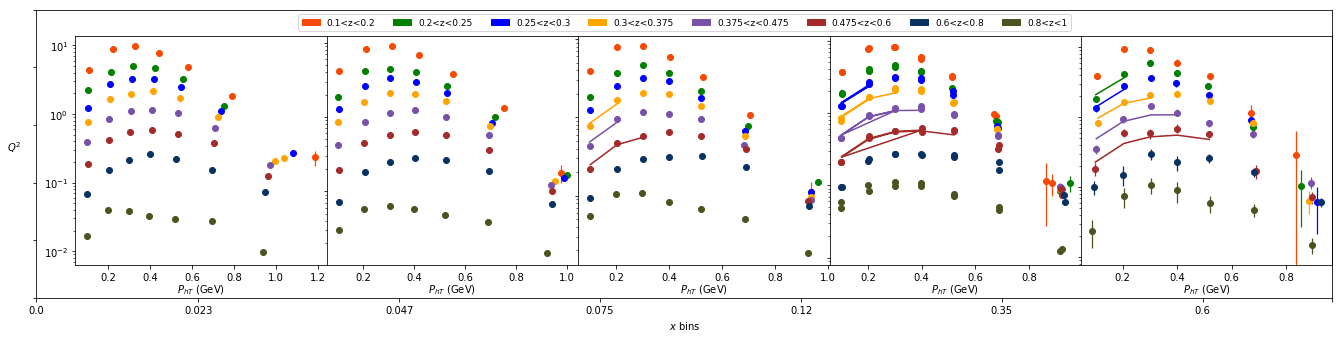

In [27]:
###############
# HermesPlot ##
###############  Reduced matix 
# initialize the figure
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

fig1=plt.figure(figsize=(18, 4),facecolor="white") # figsize; wxh in inche
globalGrid=gridspec.GridSpec(1, 1,left=0.03,right=1,top=.91,bottom=.115, wspace=0.0, hspace=0.0) # plot for subplot matrix as 1x1 matrix
innerGrid=gridspec.GridSpecFromSubplotSpec(1,5 , subplot_spec=globalGrid[0], wspace=0.0, hspace=0.0) # 5x6 subplot grid 

# figure properties:
ax=fig1.add_axes([0,0,1,1]) # axas for subplot matrix as percent of hole
#ax.yaxis.set_ticks([0,1.25,2.76,4.27,5.78,7.29,8.8,10])
ax.xaxis.set_ticks([0,1.25,2.8,4.35,5.9,7.45,9,10 ])
xticklabels = np.array([0,0.023,0.047,0.075,0.12,0.35,0.6]) 

ax.set_yticklabels("")
ax.set_xticklabels(xticklabels)
ax.set_xlabel(r"$x$ bins") # xy-lables
ax.set_ylabel(r"$Q^2$",rotation="horizontal",labelpad = 15)
#ax.grid() # grid currently off

# subplot axis proerties (unused)
Zcolor=['#F74902',"green","blue",'orange',"#7851a9","brown",'#093162','#4b5320']
Zmark=["o","o","o","o"]

# Set legend
Zpatch1 = mpatches.Patch(color=Zcolor[0], label='0.1<z<0.2')
Zpatch2 = mpatches.Patch(color=Zcolor[1], label='0.2<z<0.25')
Zpatch3 = mpatches.Patch(color=Zcolor[2], label='0.25<z<0.3')
Zpatch4 = mpatches.Patch(color=Zcolor[3], label='0.3<z<0.375')
Zpatch5 = mpatches.Patch(color=Zcolor[4], label='0.375<z<0.475')
Zpatch6 = mpatches.Patch(color=Zcolor[5], label='0.475<z<0.6')
Zpatch7 = mpatches.Patch(color=Zcolor[6], label='0.6<z<0.8')
Zpatch8 = mpatches.Patch(color=Zcolor[7], label='0.8<z<1')
          
ax.legend(handles=[Zpatch1,Zpatch2,Zpatch3,Zpatch4,Zpatch5,Zpatch6,Zpatch7,Zpatch8],
          loc='upper center',
          ncol=8,prop={'size': 9}
          )
          
for f,F in zip(range(len(pTdatmod)),pTdatmod):       
    for j,J in zip(range(len(valuedatmod)),valuedatmod):
        
        k = int(f) # kth possition for subplot on innerGrid matrix
        maskX = dat['xBin'].isin([F]) # returns boolean for all Jth xBin in dat  
        maskY = dat['Q2Bin'].isin([J]) # returns boolean for all Fth Q2Bin in dat
        
        maskX_thr = data['xBin'].isin([F]) # returns boolean for all Jth xBin in dat  
        maskY_thr = data['Q2Bin'].isin([J]) # returns boolean for all Fth Q2Bin in dat
       
        ax = fig1.add_subplot(innerGrid[k]) # add subplot in innerGrid
        xydat = dat[maskX & maskY] # subset of data for Jth xBin and Fth Q2Bin
        
        xydata = data[maskX_thr & maskY_thr] # subset of data for Jth xBin and Fth Q2Bin
        
        for z in range(len(zBin)-1): 
            maskZ = xydat["zBin"].isin([z])
            databin = xydat[maskZ]
            
            maskZ_thr = xydata["zBin"].isin([z])
            databin_thr = xydata[maskZ_thr]
            
            if f != 0:
                #AP#ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],capsize=5,linestyle="",color = Zcolor[z],elinewidth=1.25)
                ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],linestyle="",fmt="o",color = Zcolor[z],elinewidth=1.25)

                ax.set_xlabel(r"$p_T$ (GeV)",labelpad=1)
                ax.set_yscale('log')
                ax.set_yticklabels('')
                
                ax.plot(databin_thr['pT'],databin_thr['thy'],linestyle="-",color = Zcolor[z]) # theory
                ax.fill_between(databin_thr['pT'],databin_thr['thy']-databin_thr['dthy'],databin_thr['thy']+databin_thr['dthy']) # theory error
                ax.set_xlabel(r"$P_{hT}$ (GeV)",labelpad=1)
                ax.set_yticklabels('')
               
            else:
                #AP no capsize... fmt="o" #ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],capsize=5,linestyle="", color = Zcolor[z],elinewidth=1.25)
                ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],linestyle="",fmt="o", color = Zcolor[z],elinewidth=1.25)

                
                ax.plot(databin_thr['pT'],databin_thr['thy'],linestyle="-",color = Zcolor[z]) #theory
                ax.fill_between(databin_thr['pT'],databin_thr['thy']-databin_thr['dthy'],databin_thr['thy']+databin_thr['dthy']) # theory error

                
                ax.set_xlabel(r"$P_{hT}$ (GeV)",labelpad=1)
                ax.set_yscale('log')
plt.savefig("%s/%s" % (path2results, fig_hermes_dy))             

## writing descriptive stats

In [28]:
with open("sidis_hermes_torino_alexei_dy/descriptive_qt_dy.txt", "a") as f:
    f.write("%s: val, %s, sec, %s, fav, %s, unfav, %s, kfav, %s, kunfav, %s\n" % (dy, descriptive_stat[0], descriptive_stat[1], descriptive_stat[2], descriptive_stat[3],descriptive_stat[4],descriptive_stat[5]))

In [29]:
descriptive_stat

[[0.31803775834818426, 0.02345847007049021],
 [0.40410797382674846, 0.09246721823592821],
 [0.19675144955477147, 0.0039133183327877364],
 [0.1896060989406973, 0.005053559800934697],
 [0.2755202834642893, 0.016511628633215484],
 [0.26088392885200856, 0.11968176614392852]]